In [1]:
using ITensors
using Plots
using KrylovKit
using LinearAlgebra
using MKL
using ProgressMeter
using .Threads
println(Threads.nthreads())

# ITensors.op(::OpName"z", ::SiteType"S=1/2") = [1, 0, 0, -1]
# ITensors.op(::OpName"x", ::SiteType"Qubit") = [0, 1, 1, 0]
# ITensors.op(::OpName"n", ::SiteType"S=1/2") = [0, 0, 0, 1]

plotlyjs()
ITensors.disable_warn_order()

1


14

In [2]:
mutable struct RydbergObserver <: AbstractObserver
    energy_tol::Float64
    last_energy::Float64

    RydbergObserver(energy_tol=0.0) = new(energy_tol, 1000.0)
end

function ITensors.checkdone!(o::RydbergObserver; kwargs...)
    sw = kwargs[:sweep]
    energy = kwargs[:energy]
    if abs(energy - o.last_energy) / abs(energy) < o.energy_tol
        # early stopping
        return true
    end
    o.last_energy = energy
    return false
end

function ITensors.measure!(o::RydbergObserver; kwargs...)
    energy = kwargs[:energy]
    sweep = kwargs[:sweep]
    bond = kwargs[:bond]
    outputlevel = kwargs[:outputlevel]

    # if outputlevel > 0
    #     println("Sweep $sweep at bond $bond, the energy is $energy")
    # end
end

In [26]:
# assume k = 6
function blockade_radius(rabi_f)
    C6 = 1 # Interaction Coefficient for n (quantum number) = 61 (Hz)
    return (C6 / rabi_f)^(1 / 6)
end

function interaction_strength(a, b)
    # C6 = 2 * pi * 275 * 10^9 # Interaction Coefficient for n (quantum number) = 61 (Hz)
    C6 = 1
    lattice_spacing = 1 # lattice constant (micrometers)
    return C6 / (abs(a - b) * lattice_spacing)^6
end

function interactions(site)
    os = OpSum()
    for j = 1:site-1
        os += interaction_strength(site, j), "ProjUp", j, "ProjUp", site
    end
    return os
end

function rydberg(N, rabi_f, delt)
    os = OpSum()
    
    for site = 1:N
        os += 0.5 * rabi_f, "X", site
        os -= delt, "ProjUp", site
        os += interactions(site)
    end

    # println(combiner(sites)*contract(H))
    # @show H
    # display_mpo_elements(os)

    # println(os)

    return os
end

function display_mpo_elements(H)
    N = length(H)
    for n = 1:N
        println("Tensor $n of the MPO:")
        println(H[n])
        println("------")
    end
end

display_mpo_elements (generic function with 1 method)

In [5]:
os = OpSum()

N = 4
rabi_f = 1
delt = 0
sites = siteinds("Qubit", N)
    
for site = 1:N
    os += 0.5 * rabi_f, "X", site
    os -= delt, "ProjUp", site
    os += interactions(site)
end

H = MPO(os, sites)

Hitensor = ITensor(1.)
for i = 1:N
    Hitensor *= H[i]
end

A=Array(Hitensor,sites[1]',sites[2]', sites[3]',sites[4]',sites[1],sites[2], sites[3],sites[4])
matrix_data = reverse(round.(reshape(A,16,16), digits=5), dims=1)
p = heatmap(matrix_data, color=:viridis, size=(1000,1000))
for i in 1:size(matrix_data, 1)
    for j in 1:size(matrix_data, 2)
        annotate!([(j, i, text(string(matrix_data[i, j]), :center, 10, :white))])
    end
end

display(p)

# println(combiner(sites)*contract(H))
# @show H
# display_mpo_elements(os)

ArgumentError: ArgumentError: Overload of "op" or "op!" functions not found for operator name "x" and Index tags: ("Qubit,Site,n=1",).

In [5]:
println(interaction_strength(1, 2))

1.0


In [44]:
function bipartite_entropy(psi)
    b = Int(ceil(length(psi) / 2))
    # from ITensor docs
    ITensors.orthogonalize!(psi, b)
    U, S, V = svd(psi[b], (linkind(psi, b - 1), siteind(psi, b)))
    SvN = 0.0
    for n in 1:dim(S, 1)
        p = S[n, n]^2
        SvN -= p * log2(p)
    end
    return SvN
end

# code inspired from https://itensor.github.io/ITensors.jl/dev/tutorials/MPSTimeEvolution.html
function itebd(N, psi0, sites, rabi_f, delt)
    cutoff = 1E-20
    tau = 0.1
    time = 50

    gates = ITensor[]
    for j in 1:(N-2)
        s1 = sites[j]
        s2 = sites[j+1]
        s3 = sites[j+2]

        onsite_h = -1/2 * rabi_f * op("x", s1) - delt * op("n", s1)
        nn_h = interaction_strength(j, j+1) * op("n", s1) * op("n", s2)
        nnn_h = interaction_strength(j, j+2) * op("n", s1) * op("n", s3)

        onsite_Gj = exp(-tau / 2 * onsite_h)
        nn_Gj = exp(-tau / 2 * nn_h)
        nnn_Gj = exp(-tau / 2 * nnn_h)

        push!(gates, nnn_Gj)
        push!(gates, nn_Gj)
        push!(gates, onsite_Gj)
    end
    for j in N-2:1
        s1 = sites[j]
        s2 = sites[j+1]
        s3 = sites[j+2]

        onsite_h = -1/2 * rabi_f * op("x", s1) - delt * op("n", s1)
        nn_h = interaction_strength(j, j+1) * op("n", s1) * op("n", s2)
        nnn_h = interaction_strength(j, j+2) * op("n", s1) * op("n", s3)

        onsite_Gj = exp(-tau / 2 * onsite_h)
        nn_Gj = exp(-tau / 2 * nn_h)
        nnn_Gj = exp(-tau / 2 * nnn_h)

        push!(gates, nnn_Gj)
        push!(gates, nn_Gj)
        push!(gates, onsite_Gj)
    end
    # append!(gates, reverse(gates))
    
    psi = psi0

    normalize!(psi)

    for t in 0.0:tau:time
        t ≈ time && break
        psi = apply(gates, psi; cutoff)
        normalize!(psi)
    end

    return psi
end

function ground_state(N, psi0, sites, rabi_f, delt, ed_, krylov_dim=3)
    H = MPO(rydberg(N, rabi_f, delt), sites)

    nsweeps = 300
    # maxdim = [100, 100, 200, 200, 400]
    maxdim = [40, 40, 60]
    # maxdim = fill(100,nsweeps)
    cutoff = fill(1E-8, nsweeps)

    etol = 1E-8

    obs = RydbergObserver(etol)
    if ed_ == true
        energy, psi = ed(H, psi0, sites, krylov_dim)
    end
    if ed_ == false
        energy, psi = dmrg(H, psi0; nsweeps=nsweeps, maxdim=maxdim, cutoff=cutoff, observer=obs, outputlevel=0, println=false)
    end
    # eigen(H, )
    # H2 = inner(H,psi,H,psi)
    # E = inner(psi',H,psi)
    # var = H2-E^2
    # println(E)
    # println(var)
    # println()

    # combin = combiner(sites)
    # println(combin * contract(psi))
    # println(energy)
    entropy = bipartite_entropy(psi)
    return entropy, energy, psi
end

function first_excitation(N, psi0, ground_psi, sites, rabi_f, delt)
    H = MPO(rydberg(N, rabi_f, delt), sites)

    nsweeps = 300
    maxdim = [40, 40, 60]
    cutoff = fill(1E-10, nsweeps)
    weight = 1E6

    etol = 1E-10

    obs = RydbergObserver(etol)
    energy, excited_psi = dmrg(H, [ground_psi], psi0; nsweeps, maxdim, cutoff, weight=weight, observer=obs, outputlevel=0, println=false)

    # println(inner(excited_psi, ground_psi))
    return energy, excited_psi
end

function energy_gap(N, psi0, sites, rabi_f, delt)
    H = MPO(rydberg(N, rabi_f, delt), sites)

    nsweeps = 200
    maxdim = fill(100,nsweeps)
    cutoff = fill(1E-10, nsweeps)
    weight = 1E6

    etol = 1E-10

    _, ground_energy, ground_psi = ground_state(N, psi0, sites, rabi_f, delt, false)

    obs = RydbergObserver(etol)
    energy, excited_psi = dmrg(H, [ground_psi], psi0; nsweeps, maxdim, cutoff, weight=weight, observer=obs, outputlevel=0, println=false)
    gap = energy - ground_energy
    # println(inner(excited_psi, ground_psi))
    return gap
end

function avg_rydberg(psi)
    avgr = 0
    for i = 1:length(psi)
        avgr += expect(psi, "ProjUp"; sites=i)
    end
    return avgr / length(psi)
end

function measure_mps(psi)
    measurement = []
    for i = 1:length(psi)
        push!(measurement, round(expect(psi, "ProjUp"; sites=i), digits=2))
    end
    return measurement
end

function ed(H, psi0, sites, krylov_dim)
    vals, vecs, info = @time eigsolve(
        contract(H), contract(psi0), 1, :SR; ishermitian=true, tol=1e-20, krylovdim=krylov_dim, eager=true
    )
    return vals[1], MPS(vecs[1], sites)
end

function dominant_superposition(psi)

end

dominant_superposition (generic function with 1 method)

In [47]:
function stand(N, resolution, coarse, separation_assumption, start, stop, stop2, psi0, sites, ed_=true, krylov_dim=3)
    V_nn = 2 * pi * 60 * (10^6)
    V_nn = 1
    C6 = 1 # Interaction Coefficient for n (quantum number) = 61 (Hz)
    a = 1

    freq = range(start, stop=stop, length=resolution)

    Y = freq

    X = collect(range(0.0, stop=stop2, length=resolution))

    entropies = zeros(Float64, resolution, resolution)
    numbers = zeros(Float64, resolution, resolution)
    energy_gaps = zeros(Float64, resolution, resolution)
    energies = zeros(Float64, resolution, resolution)
    second = zeros(Float64, resolution, resolution)
    hover_text = [["" for i in 1:resolution] for j in 1:resolution]

    simulation_data = Any[]

    # p = Progress(resolution^2, 1)

    for i = 1:length(Y)
        for j = 1:length(X)
            # println((i - 1) * length(X) + j)
            if ((i - 1) * length(X) + j) % 5 == 0
                println((i - 1) * length(X) + j)
            end
            
            rabi_freq = C6/((a * Y[i])^6)
            delta = X[j] * rabi_freq

            entropy, energy, gs = ground_state(N, psi0, sites, rabi_freq, delta, ed_, krylov_dim)
            energy2, s2 = first_excitation(N, psi0, gs, sites, rabi_freq, delta)
            # push!(simulation_data, (rabi_freq, delta, entropy, energy, gs))

            entropies[i, j] = entropy
            numbers[i, j] = avg_rydberg(gs)
            energy_gaps[i, j] = log(energy2 - energy)
            # energies[i, j] = energy

            mps_state = measure_mps(gs)
            hover_text[i][j] = join(string.(mps_state), ", ")
            # next!(p)
        end
    end

    # compute QPT points
    # for j = 1:resolution
    #     for i = 2:resolution-1
    #         # b = (energies[i,j+1]-energies[i,j]) / (X[j+1] - X[j])
    #         # a = (energies[i, j] - energies[i, j-1]) / (X[j] - X[j-1])
    #         # hessian = abs((b - a) / (X[j+1] - X[j-1])) # not hessian
    #         # finite_diff = (2*energies[i, j] - 5*energies[i-1, j] + 4*energies[i-2, j] - energies[i-3, j]) / (Y[i] - Y[i-1])^2
    #         finite_diff = energies[i+1, j] - 2 * energies[i, j] + energies[i-1, j]
    #         finite_diff = finite_diff / (Y[i] - Y[i-1])^2
    #         second[i, j] = abs(finite_diff)
    #     end
    # end

    deltaX = (maximum(X) - minimum(X)) / length(X)
    deltaY = (maximum(Y) - minimum(Y)) / length(Y)

    # Adjust the plot limits to ensure cells are not cut off
    adjusted_xlims = (minimum(X) - 0.5 * deltaX, maximum(X) + 0.5 * deltaX)
    adjusted_ylims = (minimum(Y) - 0.5 * deltaY, maximum(Y) + 0.5 * deltaY)

    return simulation_data, heatmap(
        X, Y, energy_gaps,
        # xlims=adjusted_xlims,
        # ylims=adjusted_ylims,
        hover=hover_text,
        color=:viridis,
        aspect_ratio=:auto,
        xlabel="Δ/Ω",
        ylabel="R_b/a",
        colorbar_title="Gap ln(ε)"
    ), heatmap(
        X, Y, entropies,
        # xlims=adjusted_xlims,
        # ylims=adjusted_ylims,
        hover=hover_text,
        color=:viridis,
        aspect_ratio=:auto,
        xlabel="Δ/Ω",
        ylabel="R_b/a",
        colorbar_title="Bipartite Entropy"
    ), heatmap(
        X, Y, numbers,
        # xlims=adjusted_xlims,
        # ylims=adjusted_ylims,
        hover=hover_text,
        color=:viridis,
        aspect_ratio=:auto,
        xlabel="Δ/Ω",
        ylabel="R_b/a",
        colorbar_title="Rydberg Fraction"
    )
end


stand (generic function with 3 methods)

In [55]:
N=51
resolution=30
coarse_resolution=4
separation_assumption=2
sites = siteinds("Qubit", N)
psi0 = MPS(sites, ["Dn" for i = 1:N])
krylov_dim = 20
simulation_data1, plot1, plot2, plot3 = stand(N, resolution, coarse_resolution, separation_assumption, 0.01, 3, 4, psi0, sites, false, krylov_dim)
plot(plot1)

5


10


15


20


25


30


35


40


45


50


55


60


65


70


75


80


85


90


95


100


105


110


115


120


125


130


135


140


145


150


155


160


165


InterruptException: InterruptException:

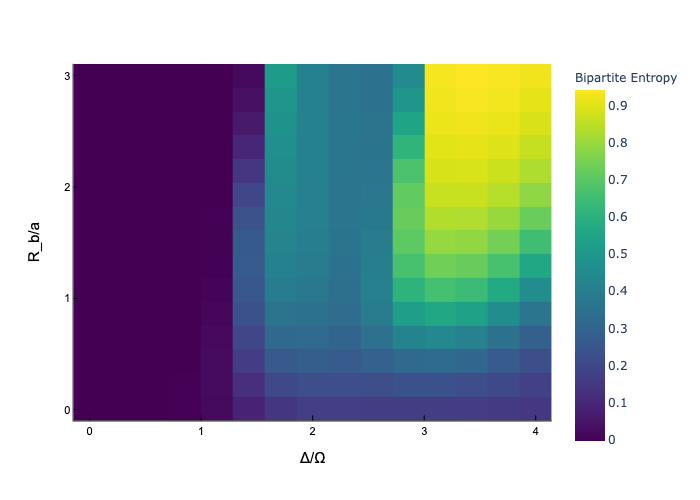

In [52]:
plot(plot2)

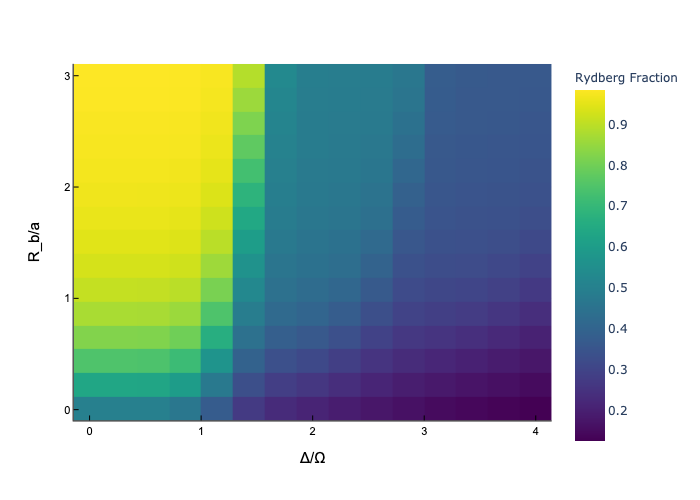

In [53]:
plot(plot3)

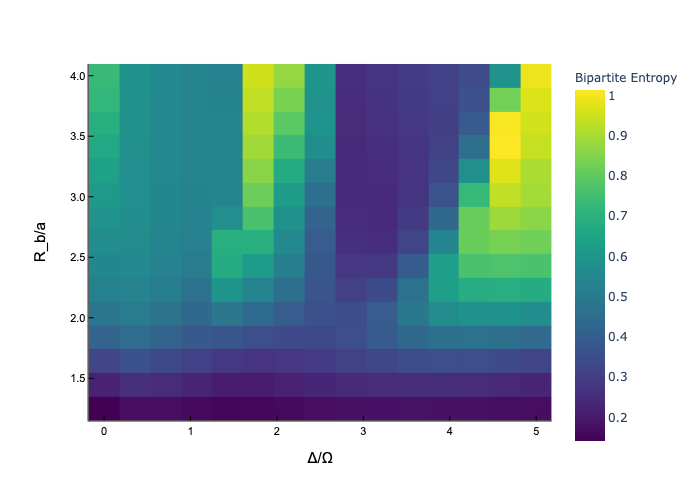

In [16]:
plot(plot1)

5


10


15


20


25


30


35


40


45


50


55


60


65


70


75


80


85


90


95


100


105


110


115


120


125


130


135


140


145


150


155


160


165


170


175


180


185


190


195


200


205


210


215


220


225


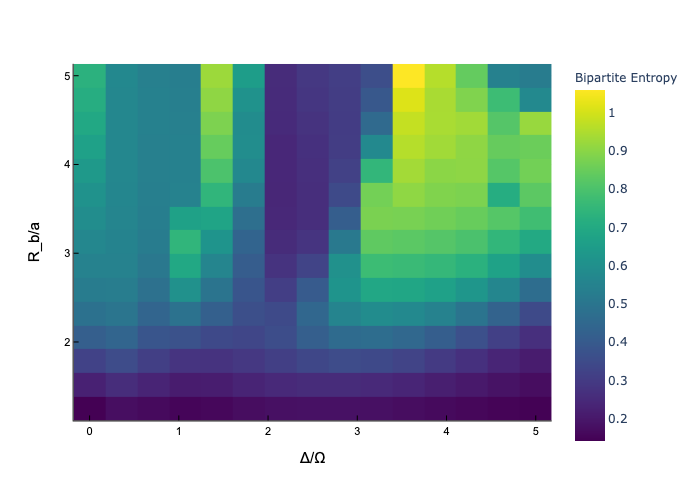

In [46]:
N=12
resolution=15
coarse_resolution=4
separation_assumption=2
sites = siteinds("S=1/2", N)
psi0 = MPS(sites, ["Dn" for i = 1:N])
krylov_dim = 20
simulation_data1, plot1, plot2 = stand(N, resolution, coarse_resolution, separation_assumption, 1.25, 5, 5, psi0, sites, false, krylov_dim)
plot(plot1)

5


10


15


20


25


30


35


40


45


50


55


60


65


70


75


80


85


90


95


100


105


110


115


120


125


130


135


140


145


150


155


160


165


170


175


180


185


190


195


200


205


210


215


220


225


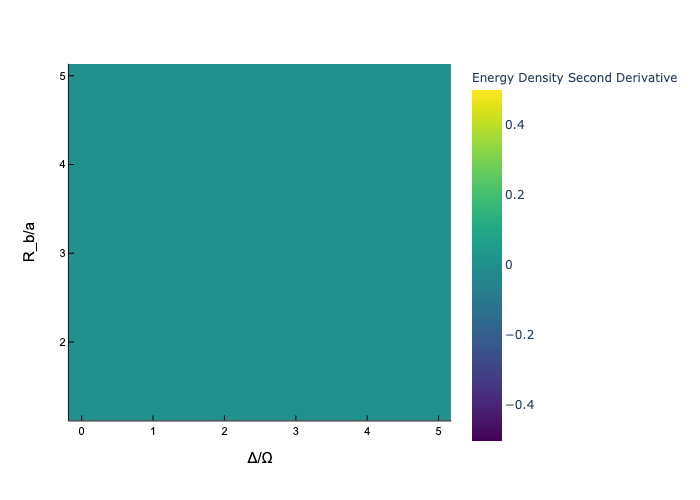

In [169]:
N=6
resolution=15
coarse_resolution=4
separation_assumption=2
sites = siteinds("S=1/2", N)
psi0 = MPS(sites, ["Dn" for i = 1:N])
krylov_dim = 20
simulation_data1, plot1, plot2 = stand(N, resolution, coarse_resolution, separation_assumption, 1.25, 5, 5, psi0, sites, false, krylov_dim)
plot(plot2)

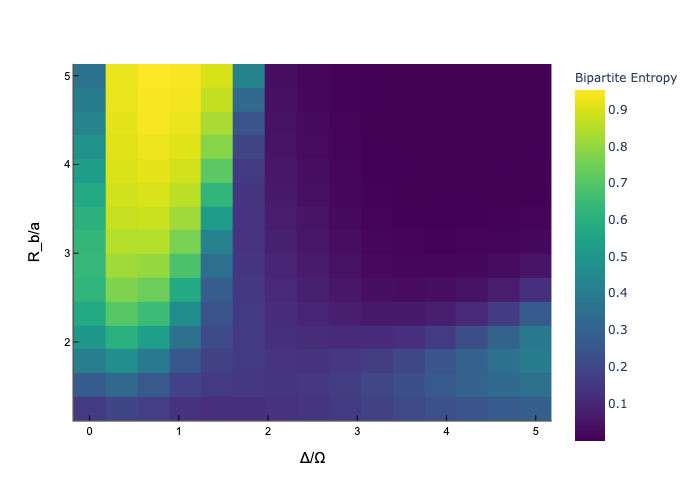

In [170]:
plot(plot1)

In [20]:
function scan(N, resolution, ratio, Y, psi0, sites)
    a = 1
    C6 = 1
    # freq = (Y.*(a/C6^(1/6))).^(-6)
    # freq = Y.^(-6)
    energies = Array{Float64}(undef, resolution)
    for i=1:resolution
        if i % 10 == 0
            println(i)
        end
        rabi_freq = C6/((a * Y[i])^6)
        delta = ratio * rabi_freq
        # println(i)
        energies[i] = ground_state(N, psi0, sites, rabi_freq, delta, false, 300)[2]
    end
    return energies
end

function centered_finite_difference(first, second, third, diff, der)
    if der == 1
        return (third - first)/(2*diff)
    end
    if der == 2
        return (third - 2*second + first)/diff^2
    end
end

function forward_finite_difference(first, second, third, diff)
    # if der == 1
    return (-3 * first + 4*second - third) / (2*diff)
    # end
    # if der == 2
        # return (2*first - 5*second + 4*third - )
    # end
end

function backward_finite_difference(first, second, third, diff)
    return (3*third - 4*second + third) / (2*diff)
end

function first_derivative(energies, diff)
    deriv = Float64[]
    push!(deriv, forward_finite_difference(energies[1], energies[2], energies[3], diff))
    for i = 2:length(energies)-1
        push!(deriv, centered_finite_difference(energies[i-1], energies[i], energies[i+1], diff, 1))
    end
    push!(deriv, backward_finite_difference(energies[end-2], energies[end-1], energies[end], diff))
    return deriv
end

# computes some finite differences
function second_derivative(energies, diff)
    deriv = Float64[]
    push!(deriv, 0)
    for i = 2:length(energies)-1
        push!(deriv, centered_finite_difference(energies[i-1], energies[i], energies[i+1], diff, 2))
    end
    push!(deriv, 0)
    return deriv
end

second_derivative (generic function with 1 method)

10


20


30


40


50


60


70


80


90


100


110


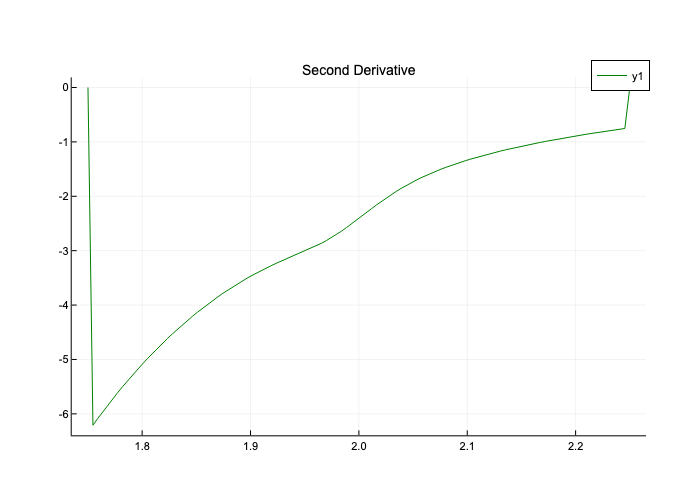

In [21]:
resolution = 110
N = 12
start = 1.75
stop = 2.25
xval = 2
sites = siteinds("S=1/2", N)
psi0 = MPS(sites, ["Dn" for i = 1:N])
Y_ = range(start, stop=stop, length=resolution)
energies_list = scan(N, resolution, xval, Y_, psi0, sites)
first_list = first_derivative(energies_list, Y_[2]-Y_[1])
second_list = second_derivative(energies_list, Y_[2]-Y_[1])

# common_plot_attrs = Dict(
#     :linewidth => 10,           # Line width
#     :titlefontsize => 14,      # Title font size
#     :legendfontsize => 30,     # Legend font size
#     :tickfontsize => 40,       # Tick label font size
#     :guidefontsize => 12       # Axis label font size
# )

p1 = plot(Y_, energies_list, title="Energy Density", color=:blue, titlefontsize=10)

# Create the second plot
p2 = plot(Y_, first_list, title="First Derivative", color=:red, titlefontsize=10)

# Create the third plot
p3 = plot(Y_, second_list, title="Second Derivative", color=:green, titlefontsize=10)

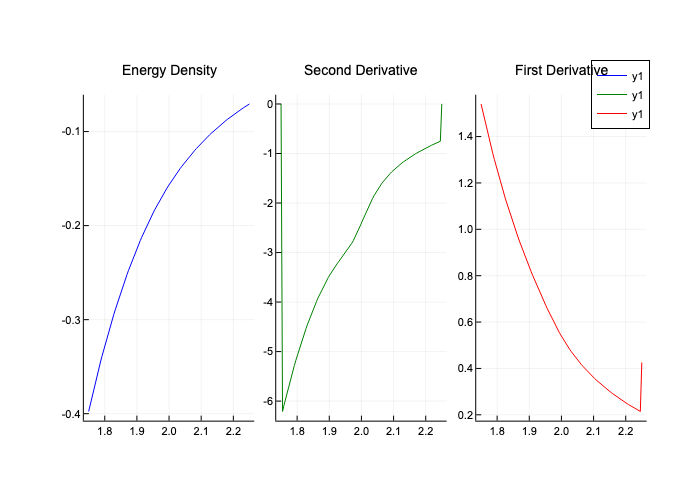

In [22]:

# Display the plots side by side
plot(p1, p3, p2, layout=(1, 3), size=(700, 200))

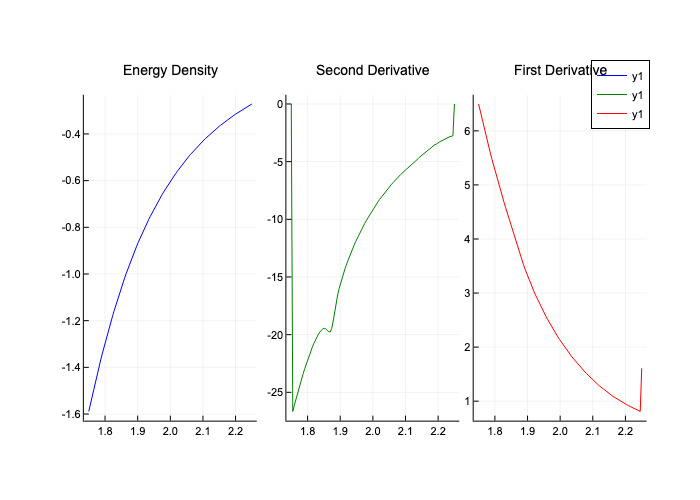

In [91]:

# Display the plots side by side
plot(p1, p3, p2, layout=(1, 3), size=(700, 200))